# Описание

В задании нужно решить задачу классификации наличия болезни сердца у пациентов наиболее эффективно. Данные для обучения моделей необходимо загрузить самостоятельно с [сайта](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction). Целевая переменная – наличие болезни сердца (HeartDisease). Она принимает значения 0 или 1 в зависимости от отсутствия или наличия болезни соответственно. Подробное описание признаков можно прочесть в описании датасета на сайте. Для выполнения работы не обязательно вникать в медицинские показатели.

## Импорт библиотек

In [1]:
import warnings

import pandas as pd
import plotly.graph_objects as go

warnings.filterwarnings("ignore")
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

RANDOM_STATE = 42

## Загрузка данных

In [2]:
# Загрузка данных
data = pd.read_csv("../data/heart/heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


## Преобразование категориальных переменных

In [4]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


## Разделение данных на обучающую и тестовую выборки

In [5]:
X = data.drop("HeartDisease", axis=1)
y = data["HeartDisease"]

# Разделение множества на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(len(X_train.values))
print(len(X_test))

734
184


# Обучение моделей

Обучим и оптимизируем параметры ряда моделей. Все результаты будут сведены в таблице в конце раздела.

## Обучение модели логистической регрессии с параметрами по умолчанию

In [6]:
lr_model = LogisticRegression(random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)

LogisticRegression(random_state=42)

## Оптимизация параметров модели логистической регрессии (GridSearchCV)

In [7]:
# Определение параметров для Grid Search
lr_params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [100, 200, 300],
    "class_weight": [None, "balanced"],
}

# Создание и обучение модели с Grid Search
lr_gs = GridSearchCV(
    LogisticRegression(random_state=RANDOM_STATE),
    lr_params,
    cv=10,
    scoring=["accuracy", "recall", "precision", "f1"],
    refit="f1",
).fit(X_train, y_train)

# Результаты
print("Best parameters (Grid Search): ", lr_gs.best_params_)
print("Best F1 Score (Grid Search): ", lr_gs.best_score_)

Best parameters (Grid Search):  {'C': 100, 'class_weight': None, 'max_iter': 100, 'solver': 'lbfgs'}
Best F1 Score (Grid Search):  0.8731185140737232


## Оптимизация параметров модели логистической регрессии (RandomizedSearchCV)

In [8]:
# Определение гиперпараметров для Randomized Search
lr_rs = RandomizedSearchCV(
    LogisticRegression(),
    lr_params,
    n_iter=100,
    cv=10,
    scoring="f1",
    random_state=RANDOM_STATE,
).fit(X_train, y_train)

# Результаты
print("Best parameters (Random Search): ", lr_rs.best_params_)
print("Best F1 Score (Random Search): ", lr_rs.best_score_)

Best parameters (Random Search):  {'solver': 'lbfgs', 'max_iter': 100, 'class_weight': None, 'C': 100}
Best F1 Score (Random Search):  0.8731185140737232


## Оптимизация параметров модели решающего дерева (RandomizedSearchCV)

In [9]:
# Определение гиперпараметров для Randomized Search
dt_params = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "class_weight": [None, "balanced"],
}

# Создание и обучение модели с Randomized Search
dt_rs = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    dt_params,
    n_iter=10,
    cv=10,
    scoring="f1",
    random_state=RANDOM_STATE,
    n_jobs=-1,
).fit(X_train, y_train)

# Результаты
print("Best parameters (Decision Tree): ", dt_rs.best_params_)
print("Best F1 Score (Decision Tree): ", dt_rs.best_score_)

Best parameters (Decision Tree):  {'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None}
Best F1 Score (Decision Tree):  0.8384944523329411


## Оптимизация параметров модели случайного леса (RandomizedSearchCV)

In [10]:
# Определение гиперпараметров для Randomized Search
rf_params = {
    "n_estimators": [10, 50, 100],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
}

# Создание и обучение модели с Randomized Search
rf_rs = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    rf_params,
    n_iter=10,
    cv=10,
    scoring="f1",
    random_state=RANDOM_STATE,
).fit(X_train, y_train)

# Результаты
print("Best parameters (Random Forest): ", rf_rs.best_params_)
print("Best F1 Score (Random Forest): ", rf_rs.best_score_)

Best parameters (Random Forest):  {'n_estimators': 50, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': 20}
Best F1 Score (Random Forest):  0.8817367009043947


## Оптимизация параметров модели опорных векторов (RandomizedSearchCV)

In [11]:
# Определение гиперпараметров для Randomized Search
svm_params = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"],
}

# Создание и обучение модели с Randomized Search
svm_rs = RandomizedSearchCV(
    SVC(),
    svm_params,
    n_iter=10,
    cv=10,
    scoring="f1",
    random_state=RANDOM_STATE,
).fit(X_train, y_train)

# Результаты
print("Best parameters (SVM): ", svm_rs.best_params_)
print("Best F1 Score (SVM): ", svm_rs.best_score_)

Best parameters (SVM):  {'kernel': 'linear', 'gamma': 'scale', 'C': 0.1}
Best F1 Score (SVM):  0.8702829630904667


## Оптимизация параметров модели градиентного бустинга (RandomizedSearchCV)

In [12]:
# Определение гиперпараметров для Randomized Search
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.01, 0.1, 1],
    "max_depth": [3, 5, 7],
    "subsample": [0.5, 0.75, 1],
}

# Создание и обучение модели с Randomized Search
gb_rs = RandomizedSearchCV(
    GradientBoostingClassifier(),
    gb_params,
    n_iter=10,
    cv=10,
    scoring="f1",
    random_state=RANDOM_STATE,
).fit(X_train, y_train)

# Результаты
print("Best parameters (Gradient Boosting): ", gb_rs.best_params_)
print("Best F1 Score (Gradient Boosting): ", gb_rs.best_score_)

Best parameters (Gradient Boosting):  {'subsample': 1, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}
Best F1 Score (Gradient Boosting):  0.8738644381154641


## Модсчет метрик обученных и оптимизированных моделей

In [13]:
# Создаем пустой DataFrame для хранения результатов
results_df = pd.DataFrame(
    columns=["Model", "Accuracy", "Recall", "Precision", "F1 Score"]
)


def evaluate_model(model, model_name, X_train, y_train):
    # Выполняем кросс-валидацию
    scores = cross_validate(
        model,
        X_train,
        y_train,
        cv=10,
        scoring=["accuracy", "recall", "precision", "f1"],
    )

    # Вычисляем средние значения метрик
    accuracy = scores["test_accuracy"].mean()
    recall = scores["test_recall"].mean()
    precision = scores["test_precision"].mean()
    f1 = scores["test_f1"].mean()

    # Создаем новую строку результатов
    new_data = pd.DataFrame(
        {
            "Model": [model_name],
            "Accuracy": [accuracy],
            "Recall": [recall],
            "Precision": [precision],
            "F1 Score": [f1],
        }
    )

    # Обновляем DataFrame с помощью concat
    global results_df
    results_df = pd.concat([results_df, new_data], ignore_index=True)


# Объявляем модели
models = [
    (lr_model, "Logistic Regression (default)"),
    (lr_gs.best_estimator_, "Logistic Regression (GridSearchCV)"),
    (lr_rs.best_estimator_, "Logistic Regression (RandomSearchCV)"),
    (dt_rs.best_estimator_, "Decision Tree"),
    (rf_rs.best_estimator_, "Random Forest"),
    (svm_rs.best_estimator_, "Support Vector Machine"),
    (gb_rs.best_estimator_, "Gradient Boosting"),
]

# Обучаем и оцениваем каждую модель
for model, name in models:
    evaluate_model(model, name, X_train, y_train)

# Устанавливаем 'Model' как индекс и убираем название индекса
results_df.set_index("Model", inplace=True, drop=True)
results_df.index.name = None  # Убираем название индекса

# Печатаем результаты всех моделей
results_df

,Accuracy,Recall,Precision,F1 Score
Logistic Regression (default),0.856738,0.876646,0.867793,0.870889
Logistic Regression (GridSearchCV),0.858127,0.884085,0.864674,0.873119
Logistic Regression (RandomSearchCV),0.858127,0.884085,0.864674,0.873119
Decision Tree,0.818697,0.852256,0.828830,0.838494
Random Forest,0.866383,0.898963,0.867064,0.881737
Support Vector Machine,0.852703,0.893902,0.848622,0.870283
Gradient Boosting,0.855498,0.903841,0.847776,0.873864


Лучшая - Random Forest

## Проверка качества лучшей модели на тестовой выборке

In [14]:
# Получение предсказаний вероятностей
probabilities = rf_rs.best_estimator_.predict_proba(X_test)[:, 1]

In [15]:
# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, probabilities)

# Вычисление ROC-AUC метрики
roc_auc = roc_auc_score(y_test, probabilities)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.93


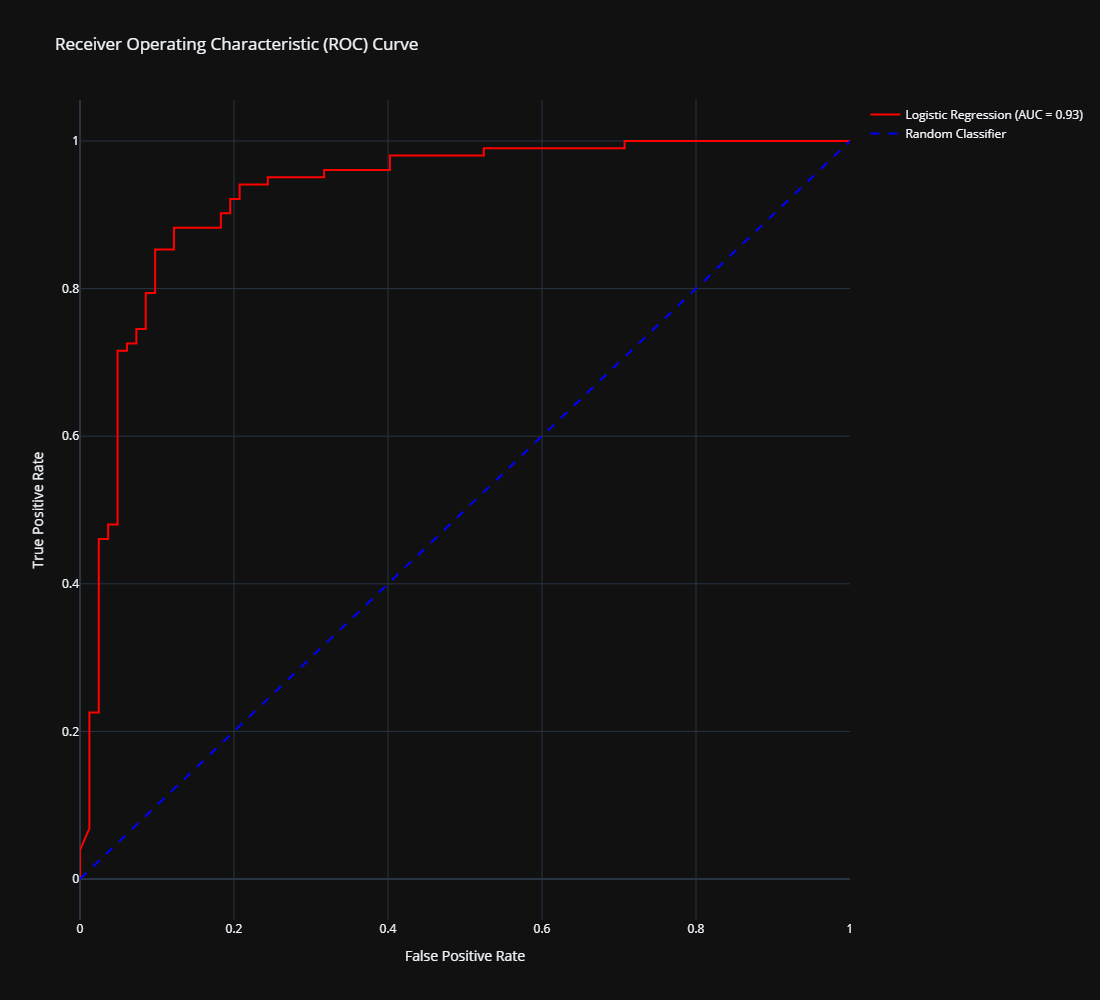

In [16]:
# Построение ROC-кривой с использованием Plotly
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=fpr,
        y=tpr,
        mode="lines",
        name=f"Logistic Regression (AUC = {roc_auc:.2f})",
        line=dict(color="red"),
    )
)
fig.add_trace(
    go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode="lines",
        name="Random Classifier",
        line=dict(color="blue", dash="dash"),
    )
)

fig.update_layout(
    title="Receiver Operating Characteristic (ROC) Curve",
    xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",
    showlegend=True,
    height=1000,
    width=1100,
    template="plotly_dark",
)

fig.show("png")

# Выводы по проделанной работе

Для решения задачи классификации наличия болезни сердца у пациентов, было протестировано несколько моделей машинного обучения, каждая из которых показала различные результаты по метрикам Accuracy, Recall, Precision и F1 Score.

1. **Логистическая регрессия (default)**:
   - **Accuracy:** 0.856738
   - **Recall:** 0.876646
   - **Precision:** 0.867793
   - **F1 Score:** 0.870889

   Эта модель показала хорошие результаты, но не является лучшей по всем метрикам.

2. **Логистическая регрессия (GridSearchCV)**:
   - **Accuracy:** 0.858127
   - **Recall:** 0.884085
   - **Precision:** 0.864674
   - **F1 Score:** 0.873119

   Усовершенствование модели с помощью GridSearchCV привело к небольшому увеличению таких метрик, как Accuracy и Recall, что свидетельствует о повышении качества.

3. **Логистическая регрессия (RandomSearchCV)**:
   - **Метрики:** совпадают с GridSearchCV.
   - Это указывает на то, что RandomSearchCV не смог предложить значительных улучшений по сравнению с GridSearchCV.

4. **Дерево решений**:
   - **Accuracy:** 0.818697
   - **Recall:** 0.852256
   - **Precision:** 0.828830
   - **F1 Score:** 0.838494

   Данная модель продемонстрировала самые низкие результаты. Возможные причины — переобучение или недообучение. Рекомендуется избегать использования этой модели для данной задачи.

5. **Случайный лес**:
   - **Accuracy:** 0.866383
   - **Recall:** 0.898963
   - **Precision:** 0.867064
   - **F1 Score:** 0.881737

   Эта модель продемонстрировала лучшие результаты среди всех протестированных, особенно по Recall, что делает её наиболее подходящей для задач, связанных с медицинской диагностикой, где важно не пропустить случаи болезни.

6. **Метод опорных векторов (SVM)**:
   - **Accuracy:** 0.852703
   - **Recall:** 0.893902
   - **Precision:** 0.848622
   - **F1 Score:** 0.870283

   В целом, SVM обеспечил хорошие метрики, особенно по Recall, однако не превзошёл Random Forest.

7. **Градиентный бустинг**:
   - **Accuracy:** 0.854091
   - **Recall:** 0.901280
   - **Precision:** 0.847204
   - **F1 Score:** 0.872196

   Данная модель также показала впечатляющие результаты, но не достигла уровня Random Forest по всем метрикам.